In [1]:
from sys import path
path.append("../")

# ARDC Training: Python Notebooks
Task-A: Cloud-free Mosaics and K-means Clustering

> ### Import the Datacube Configuration

In [2]:
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/psycopg2-2.7.7-py3.6-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


>### Browse the available Data Cubes   

In [3]:
list_of_products = dc.list_products()
netCDF_products = list_of_products[list_of_products['format'] == 'NetCDF']
# netCDF_products

>### Pick a product  
>Use the platform and product names from the previous block to select a Data Cube.  

In [4]:
# Change the data platform and data cube here

platform = "LANDSAT_7"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_ghana"
# product = "ls7_ledaps_kenya"
# product = "ls7_ledaps_senegal"
# product = "ls7_ledaps_sierra_leone"
# product = "ls7_ledaps_tanzania"
product = "ls7_ledaps_vietnam"

# Get Coordinates
descriptor = api.get_query_metadata(product, platform)
latitude_extents = descriptor['lat_extents']
longitude_extents = descriptor['lon_extents']
time_extents = descriptor['time_extents']

> #### Display Latitude-Longitude and Time Bounds of the Data Cube

In [5]:
print("Latitude Extents:", latitude_extents)
print("Longitude Extents:", longitude_extents)
print("Time Extents:", time_extents)

Latitude Extents: (9.1762906272858, 13.964939912344285)
Longitude Extents: (102.4041694654867, 108.9310588253174)
Time Extents: (datetime.datetime(1999, 9, 8, 3, 13, 19), datetime.datetime(2016, 12, 29, 3, 10))


# Visualize Data Cube Region

In [6]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

> ### Pick a smaller analysis region and display that region
Try to keep your region to less than 0.2-deg x 0.2-deg for rapid processing
Pick the time extents for your mosaic product (keep to 1 year or less)

In [7]:
## Vietnam - Central Lam Dong Province ##
longitude_extents = (107.80, 108.00)
latitude_extents  = (11.70, 11.90)

time_extents = ('2015-01-01', '2016-01-01')
print ( time_extents )

('2015-01-01', '2016-01-01')


In [8]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## Load the dataset and the required spectral bands or other parameters
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [9]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
landsat_dataset
#view the dimensions and sample content from the cube

<xarray.Dataset>
Dimensions:    (latitude: 743, longitude: 743, time: 19)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-09T03:06:13 ... 2015-12-27T03:08:59
  * latitude   (latitude) float64 11.9 11.9 11.9 11.9 ... 11.7 11.7 11.7 11.7
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 ... 108.0 108.0 108.0
Data variables:
    red        (time, latitude, longitude) int16 514 457 382 419 ... 442 406 332
    green      (time, latitude, longitude) int16 482 421 381 401 ... 451 431 332
    blue       (time, latitude, longitude) int16 296 257 238 276 ... 282 263 262
    nir        (time, latitude, longitude) int16 2457 2331 2288 ... 2784 2329
    swir1      (time, latitude, longitude) int16 1774 1826 1568 ... 1873 1341
    swir2      (time, latitude, longitude) int16 1003 1057 867 ... 1063 1117 664
    pixel_qa   (time, latitude, longitude) int32 66 66 66 66 66 ... 66 66 66 66
Attributes:
    crs:      EPSG:4326

# Display Example Images  

>#### Single band visualization   
> For a quick inspection, let's look at two images. The first image will allow the selection of any band (red, blue, green, nir, swir1, swir2) to produce a grey-scale image of any band. The second image will mask clouds with bright red on an RGB image. 
> Select the desired acquisition (time slice) in the block below. You can select from 1 to #, where the max value is the number of time slices noted in the block above. Change the comment statements below to select the bands for the first image.

In [11]:
acquisition_number = 2
# select an acquisition number from 1 to "time" using the array limits above

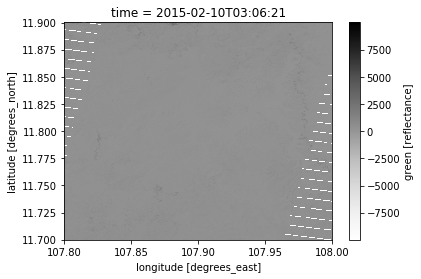

In [12]:
%matplotlib inline
#landsat_dataset.red.isel(time = acquisition_number).plot(cmap = "Greys")
landsat_dataset.green.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.blue.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.nir.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir1.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir2.isel(time = acquisition_number).plot(cmap = "Greys")

>#### Define Cloud Masking Function   
Removes clouds and cloud shadows based on the Landsat pixel QA information
This is only for reference ... nothing to modify here

In [13]:
import numpy as np

def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def remove_clouds(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return dataset.where(a_clean_mask)

> #### Mask clouds from your selected acquisition and visualize the scene and mask 
Now we will look at two RGB images where the second image includes the cloud, cloud shadow and no data mask in RED. Also, the scene is the same as the acquistion selected above.

In [14]:
cloud_mask = generate_cloud_mask(landsat_dataset)
cloudless = remove_clouds(landsat_dataset)

(<Figure size 720x28155.8 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c5fdca748>)

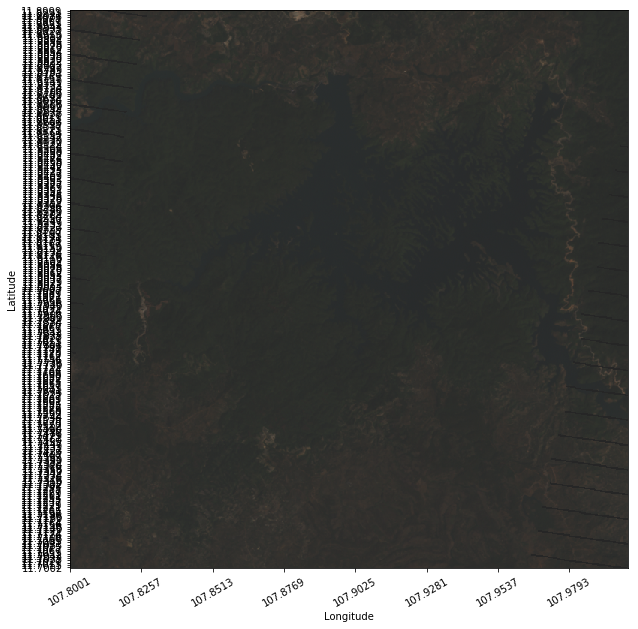

In [15]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(landsat_dataset,at_index = acquisition_number)

(<Figure size 720x28155.8 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c50707cc0>)

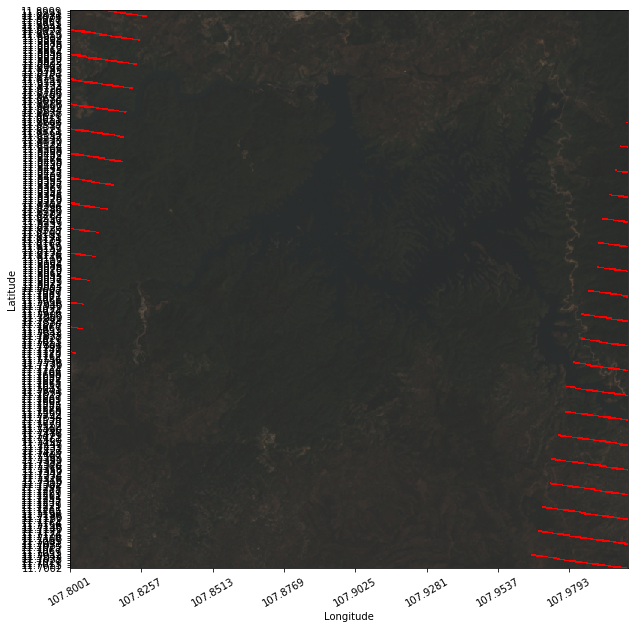

In [16]:
red = [255,0,0]
rgb(landsat_dataset,at_index = acquisition_number,paint_on_mask = [(cloud_mask, red)])


# Cleaning up the clouds and creating a cloud-free mosaic
Remember that this process will filter clouds from the entire time series stack

>** Most Recent Pixel Mosaic **   
>Masks clouds from imagery and uses the most recent cloud-free pixels.  

In [17]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [18]:
recent_composite = mrf_mosaic(landsat_dataset)

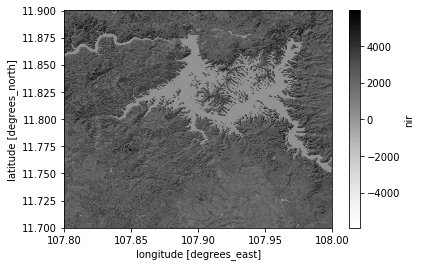

In [19]:
recent_composite.nir.plot(cmap = "Greys")

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c5f674a90>)

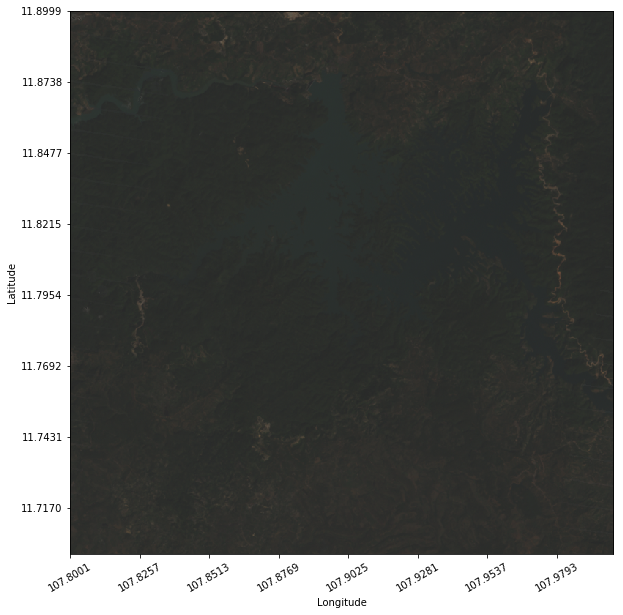

In [20]:
rgb(recent_composite)

----  
> **Median Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series  

In [21]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def median_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [22]:
median_composite = median_mosaic(landsat_dataset)

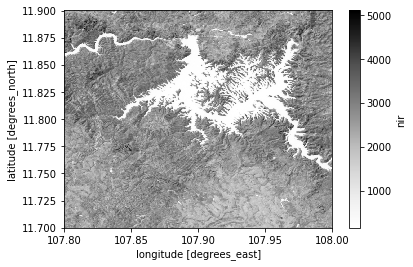

In [23]:
median_composite.nir.plot(cmap = "Greys")

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c5f5c9780>)

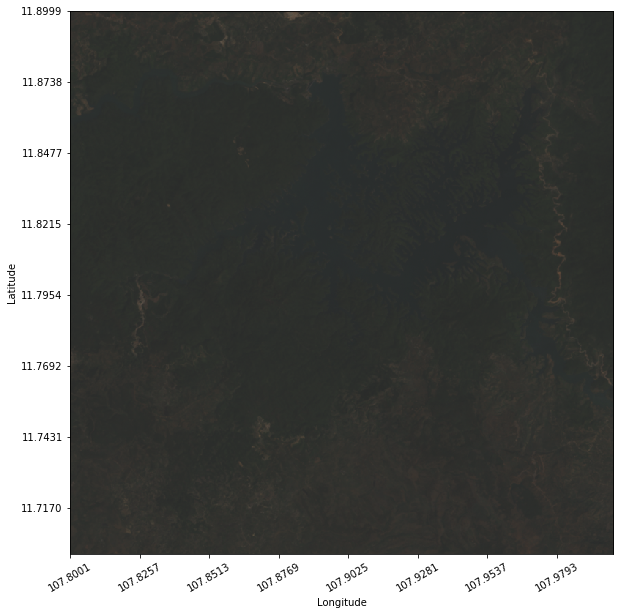

In [24]:
rgb(median_composite)

## Select bands used for clustering

In [25]:
#cluster_bands = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir']
cluster_bands = ['red', 'green', 'blue', 'swir1']

# Perform K-Means clustering and view the output

In [26]:
def figure_ratio(ds, fixed_width = 10):
    width = fixed_width
    height = len(ds.latitude) * (fixed_width / len(ds.longitude))
    return (width, height)

In [27]:
from utils.data_cube_utilities.dc_clustering import kmeans_cluster_dataset

# change the number of clusters in the line below, as desired
# this example uses the "median composite" image from above
classification_x =  kmeans_cluster_dataset(median_composite, cluster_bands, n_clusters=8)

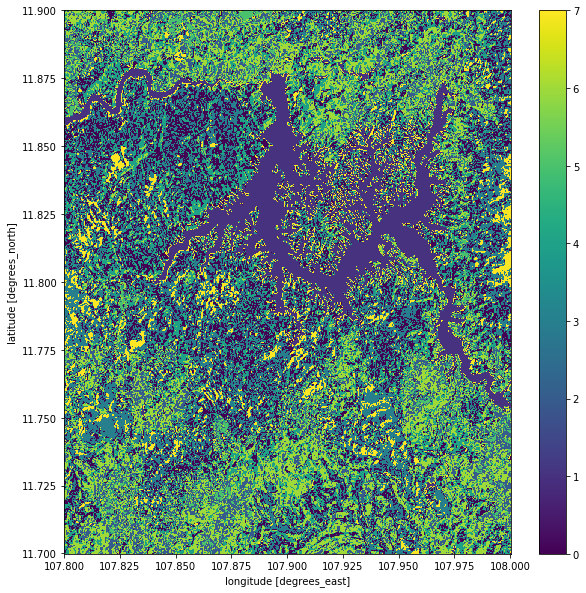

In [28]:
# plot the k-mean classification result 
classification_x.plot(figsize = figure_ratio(classification_x))